# Import dependencys

In [1]:
import numpy as np
import pickle
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
import sys
sys.path.append("../chembl_analyser/module/")
from calcula_tanimoto import *

In [3]:
from ddc_pub import ddc_v3 as ddc

In [4]:
import molvecgen

In [5]:
model_name = "models/pcb_model"
model = ddc.DDC(model_name=model_name)

Initializing model in test mode.
Loading model.
'mol_to_latent_model' not found, setting to None.


/home/alfredogdso/.conda/envs/ddc/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Loading finished in 1 seconds.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Latent_Input (InputLayer)       [(None, 7)]          0                                            
__________________________________________________________________________________________________
Decoder_Inputs (InputLayer)     [(None, 142, 35)]    0                                            
__________________________________________________________________________________________________
latent_to_states_model (Model)  [(None, 256), (None, 18432       Latent_Input[0][0]               
__________________________________________________________________________________________________
batch_model (Model)             (None, 142, 35)      1364771     Decoder_Inputs[0][0]             
                                                               

# Load model pre trained

In [6]:
qsar_model_name = "models/qsar_model.pickle"
with open(qsar_model_name, "rb") as file:
    qsar_model = pickle.load(file)["classifier_sv"]

/home/alfredogdso/.conda/envs/ddc/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, QED
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
#We suppres stdout from invalid smiles and validations
from rdkit import rdBase
rdBase.DisableLog ( 'rdApp.*')

In [8]:
def get_descriptors(mol):
    logp  = Descriptors.MolLogP(mol)
    tpsa  = Descriptors.TPSA(mol)
    molwt = Descriptors.ExactMolWt(mol)
    hba   = rdMolDescriptors.CalcNumHBA(mol)
    hbd   = rdMolDescriptors.CalcNumHBD(mol)
    qed   = QED.qed(mol)
     
                     
    # Calculate fingerprints
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2, nBits=2048)
    ecfp4 = np.zeros((2048,))
    DataStructs.ConvertToNumpyArray(fp, ecfp4) 
    # Predict activity and pick only the second component
    active_probability = qsar_model.predict_proba([ecfp4])[0][1]
    return [logp, tpsa, molwt, qed, hba, hbd, active_probability]

## Set target for study

In [9]:
smiles_target = 'CN1CCN(C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@H](/C=C/S(=O)(=O)c2ccccc2)CCc2ccccc2)CC1'

## Show target 2d

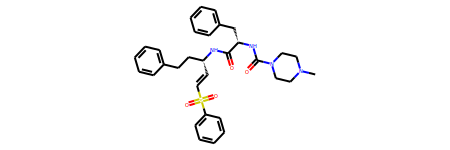

[3.659900000000002,
 98.82,
 574.261376696,
 0.36436025553250234,
 5,
 2,
 0.0002548531977814712]

In [10]:
mol = Chem.MolFromSmiles(smiles_target)
display(mol)
conditions = get_descriptors(mol)
conditions

## Set conditions regression

In [11]:
target = np.array(conditions)
#smiles_out, _ = model.predict(latent=target, temp=1)
#Chem.MolFromSmiles(smiles_out)

## Set numbers of interactions in regression

In [12]:
#model.batch_input_length = 256
smiles_out = []
for i in range(100):
    smiles, _ = model.predict_batch(latent=target.reshape(1,-1), temp=1.0)
    smiles_out.append(smiles)
smiles_out = np.concatenate(smiles_out)
smiles_out.shape

/run/media/alfredogdso/hd/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/run/media/alfredogdso/hd/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/run/media/alfredogdso/hd/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/run/media/alfredogdso/hd/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/run/media/alfredogdso/hd/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o) / temp
/run/media/alfredogdso/hd/alverad/notebook/Deep-Drug-Coder/ddc_pub/ddc_v3.py:1199: RuntimeWarning: divide by zero encountered in log
  nextCharProbs = np.log(o)

(25600,)

In [13]:
mols = [Chem.MolFromSmiles(smi) for smi in smiles_out]

## Remove invalid smille 

In [14]:
def sanitize(mol):
    try:
        Chem.SanitizeMol(mol)
        return mol
    except Exception as e:
        print(e)
         
sani_mols = [sanitize(mol) for mol in mols if mol != None]

Sanitization error: Explicit valence for atom # 6 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 34 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 12 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 29 N, 5, is greater than permitted


In [15]:
len(sani_mols)

22432

In [16]:
len(sani_mols)/len(smiles_out)

0.87625

## Calculate Properties with rdkit

In [17]:
properties = [[Chem.MolToSmiles(mol)] + get_descriptors(mol) for mol in sani_mols if mol != None]
import pandas as pd
target_names = ["Smiles", "logp", "tpsa", "molwt", "qed", "hba", "hbd", "active_probability"]
data = pd.DataFrame(properties, columns=target_names)

In [18]:
data.sort_values(by='active_probability', ascending=False)

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability
14903,CC(C)c1ccc(C(=O)NCCCCN2CCN(C(=O)CC3CCN(C(=O)C(...,3.66290,98.98000,575.38354,0.37661,5,2,0.92727
16995,CCCCCCCN1CCC=CCc2ccccc2CC(=O)NCC(=O)NCC(=O)N(C...,3.83780,110.85000,575.34715,0.27550,5,3,0.86936
12702,NS(=O)(=O)c1ccc2[nH]c3c(c2c1)Cc1ccc(CN2CCN(CCC...,3.43410,108.73000,582.07479,0.34030,6,2,0.85636
12034,C=C(Cc1ccc(NS(C)(=O)=O)c(F)c1)C(=O)N1CCN(CCNC(...,3.80190,98.82000,578.23630,0.35688,5,2,0.80649
21932,Cc1c(C(=O)NCCC2CC2)cccc1S(=O)(=O)N1CCCC(C)(C(=...,3.88032,98.82000,580.30833,0.39335,5,2,0.80218
...,...,...,...,...,...,...,...,...
16191,O=C1N(Cc2ccccc2)C(Cc2ccccc2)C(O)C(O)C(Cc2ccccc...,4.39860,98.15000,570.21884,0.32740,5,2,0.00000
5659,O=C(CN1C(=O)N(CC(=O)N2CCCCC2)C(Cc2ccccc2)C(O)C...,3.56380,101.39000,569.28897,0.38403,5,2,0.00000
15940,O=C(CS(=O)(=O)c1ccccc1)NN=Cc1c(Br)c(Br)c(Br)n2...,3.54580,92.90000,575.81020,0.28471,6,1,0.00000
12093,COc1ccc(CN2C(=O)C(=O)N(Cc3ccccc3)C(Cc3ccccc3)C...,4.01060,90.31000,564.26242,0.30007,5,2,0.00000


### Show Data Smile with Warhead sorted by active_probability

In [21]:
data.loc[data.Smiles.str.contains('#')].sort_values(by='active_probability', ascending=False)

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability
9888,CN(C)CCN1C(=O)N(CCc2c[nH]c3cc(C(=O)N4CCNCC4)cc...,4.41508,98.71000,589.31652,0.31730,5,2,0.60242
6241,CC(C)CN1CC(=O)NC(C#Cc2ccc(C(=O)NCc3ccc(F)cc3)c...,3.54880,95.58000,575.22541,0.38084,5,2,0.38831
14460,CCCC=NC(=O)C1Cc2cc(C#Cc3ccccc3)ccc2CN1C(=O)Cc1...,3.90680,100.10000,576.27366,0.32836,5,2,0.25658
5083,CC#CC1CCCN1CCN(C)S(=O)(=O)c1ccc2[nH]cc(C(=O)NC...,4.02350,102.58000,576.27703,0.33588,5,2,0.24430
1988,CC1CN(C)C(=S)N(Cc2ccoc2)C(=O)N(Cc2ccc(C#CCO)cc...,3.40410,98.49000,574.22499,0.36418,6,2,0.23760
...,...,...,...,...,...,...,...,...
10491,C#Cc1ccc(CC(NC(=O)CCS(=O)(=O)c2ccc(Br)cc2)C(=O...,3.63360,105.23000,575.03260,0.29924,5,2,0.00004
9015,COCC(C(C#N)NC(CC(=O)NCc1ccc(Br)cc1)c1ccccc1)S(...,4.30848,108.29000,583.11404,0.31023,6,2,0.00004
11263,CCC1(Cc2ccccc2)NC(C#CCCl)(CC)N(CC(=O)Nc2ccc(S(...,3.58140,98.82000,570.20675,0.35462,5,2,0.00004
15292,C#CCC(NC(=O)c1cc(C)cc(C)c1)C(=O)NC(Cc1ccccc1)C...,3.62364,108.05000,574.31552,0.29748,5,2,0.00002


## Calculate tanimoto for Pivo-based ligands

In [24]:
data_com_tanimoto = calcula_tanimoto(smiles_target, data, 4)

In [25]:
data_com_tanimoto

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability,i_tanimoto
0,CCC(NC(=O)CC1CC(C(=O)NC(C)C(Br)CBr)=N1)c1cc(-c...,4.285820000000003,96.34,577.0687993680001,0.4111292820053266,5,2,0.006344109529855956,0.33000
1,C=c1c(=N)c(C(=O)NCC(=O)N(C)c2ccccc2)nn(CCc2ccc...,2.8227700000000002,91.08000000000001,569.1661724840001,0.4292562641265874,5,2,0.0019471001793223152,0.36000
2,CCCOc1ccccc1C=C1CC2(C)C(=O)Nc3cc(C(=O)N4CCN(C)...,4.493100000000004,82.19,570.245390196,0.5361026062810859,5,1,0.006104423538446675,0.40000
3,CCc1cc(Cl)ccc1S(=O)(=O)NC(CNCC(=O)N(CC)CC)Cc1c...,3.7944200000000032,98.82000000000001,576.253704472,0.37791242617446713,5,2,0.0018767724874329207,0.37000
4,Cc1c(Br)c(CCC(=O)N2CSCC2C(=O)NC(Cc2ccc(-c3cccc...,3.8042200000000026,104.53,584.1092885080001,0.3961557555050881,6,2,0.006026242546127634,0.41000
...,...,...,...,...,...,...,...,...,...
5602,CN(C)CCCNC(=O)c1ccc(N=c2[nH]cnc3ccc(N4CCN(C(=O...,3.6071000000000026,100.16999999999997,582.2633782920001,0.4147307085162802,6,2,0.009202335540850473,0.35000
5603,O=C1N(Cc2ccncc2)c2cc(C=c3[nH]c(=O)c(=Cc4cccc(C...,3.7631000000000023,99.43,579.0375741999999,0.3586259611327509,5,2,0.01168649510218114,0.37000
5604,CC1(C)C(=O)N(c2cccc(C(=O)NCCN)c2)C(=S)N1CCN(C(...,3.7124000000000015,98.97999999999999,565.195917228,0.38412882051215974,5,2,0.002416540583656762,0.36000
5605,O=C1CN(C(=O)Cc2ccc(C(c3cn(Cc4ccccc4)nn3)C3CNC3...,2.8008000000000006,112.46000000000001,577.2801379800001,0.29991620035104644,7,2,0.005279479596560405,0.39000


### Convert datatypes

In [35]:
data_com_tanimoto.active_probability = data_com_tanimoto.active_probability.astype(float)

### Sort by indices

In [40]:
alvos = data_com_tanimoto.loc[(data_com_tanimoto.i_tanimoto > 0.46) & (data_com_tanimoto.active_probability > 0) & (data_com_tanimoto.Smiles.str.contains("#"))]
alvos

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability,i_tanimoto
1618,C#CC(C(C)C)C(Cc1cccnc1)NC(=O)N1CCN(C(=O)C(Cc2c...,3.3198000000000016,111.71000000000001,579.2845546640001,0.3582251928653273,5,2,0.00196,0.50000
2526,C#CCN(C(=O)CCc1ccc(F)cc1)C(CC(C)C)C(=O)NC(CC)C...,3.249500000000002,112.65,571.251620536,0.33828899195745754,5,2,0.01156,0.47000
1493,Cc1ccc(S(=O)(=O)CC#CCN2C(=O)N(CCCC(=O)NCc3cccc...,3.7222200000000027,98.82,572.2457266319999,0.3414997763248999,5,2,0.00046,0.48000
2865,C#CCCNC(=O)C(Cc1ccccc1)NC(=O)C1CC(S(=O)(=O)c2c...,3.623800000000001,95.58000000000001,577.180205184,0.26805398164585825,5,2,0.00787,0.48000
3366,C=CCN(Cc1ccccc1)C(=O)NC(Cc1ccc(C#CC)c(F)c1)C(=...,4.369000000000004,96.96999999999998,577.2951995999999,0.2723699678929894,5,2,0.00099,0.47000
3972,COCCNC(=O)NC(Cc1ccccc1)C(=O)N1CCN(C(=O)OCc2ccc...,3.424100000000002,100.21000000000001,568.2685702519999,0.3045009293672907,5,2,0.00017,0.52000
1223,CN(C)C(=O)NC(Cc1ccc(NCCCC#Cc2cncc(F)c2)cc1)C(=...,3.7538000000000027,97.87999999999998,578.338067456,0.3490418059322869,5,2,0.01931,0.49000
5381,N#CCC1NC(=S)N(CCCCCN2C(=O)C(Cc3ccccc3)NC(=O)C2...,3.1486800000000006,108.78,600.2882601399999,0.3014216233567725,5,2,0.01034,0.48000
553,CCCC(CNC)N1CCN(C(=O)C(Cc2ccc(Cl)cc2Cl)NC(=O)N(...,4.1500800000000035,91.71000000000001,572.243329816,0.42172941302613165,5,2,0.02511,0.51000
1446,C#CCN(CCCOC)C(=O)NC(Cc1ccccc1)C(=O)N1CCCC1C(=O...,3.5114000000000027,100.21000000000001,576.3311705079999,0.24978402618820134,5,2,0.00386,0.53000


In [41]:
smiles = alvos.Smiles
prob = alvos.active_probability
tani = alvos.i_tanimoto

In [42]:
smiles = smiles.to_numpy().tolist()
prob = [f"{prob*100:0.2f}%" for prob in prob.to_numpy().tolist()]
tani = [f"{tani*100:0.2f}%" for tani in tani.to_numpy().tolist()]

In [43]:
mols = [Chem.MolFromSmiles(smile) for smile in smiles]

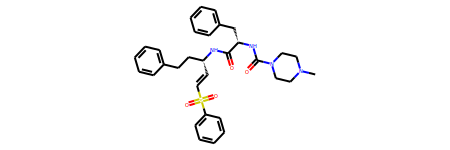

In [44]:
mol

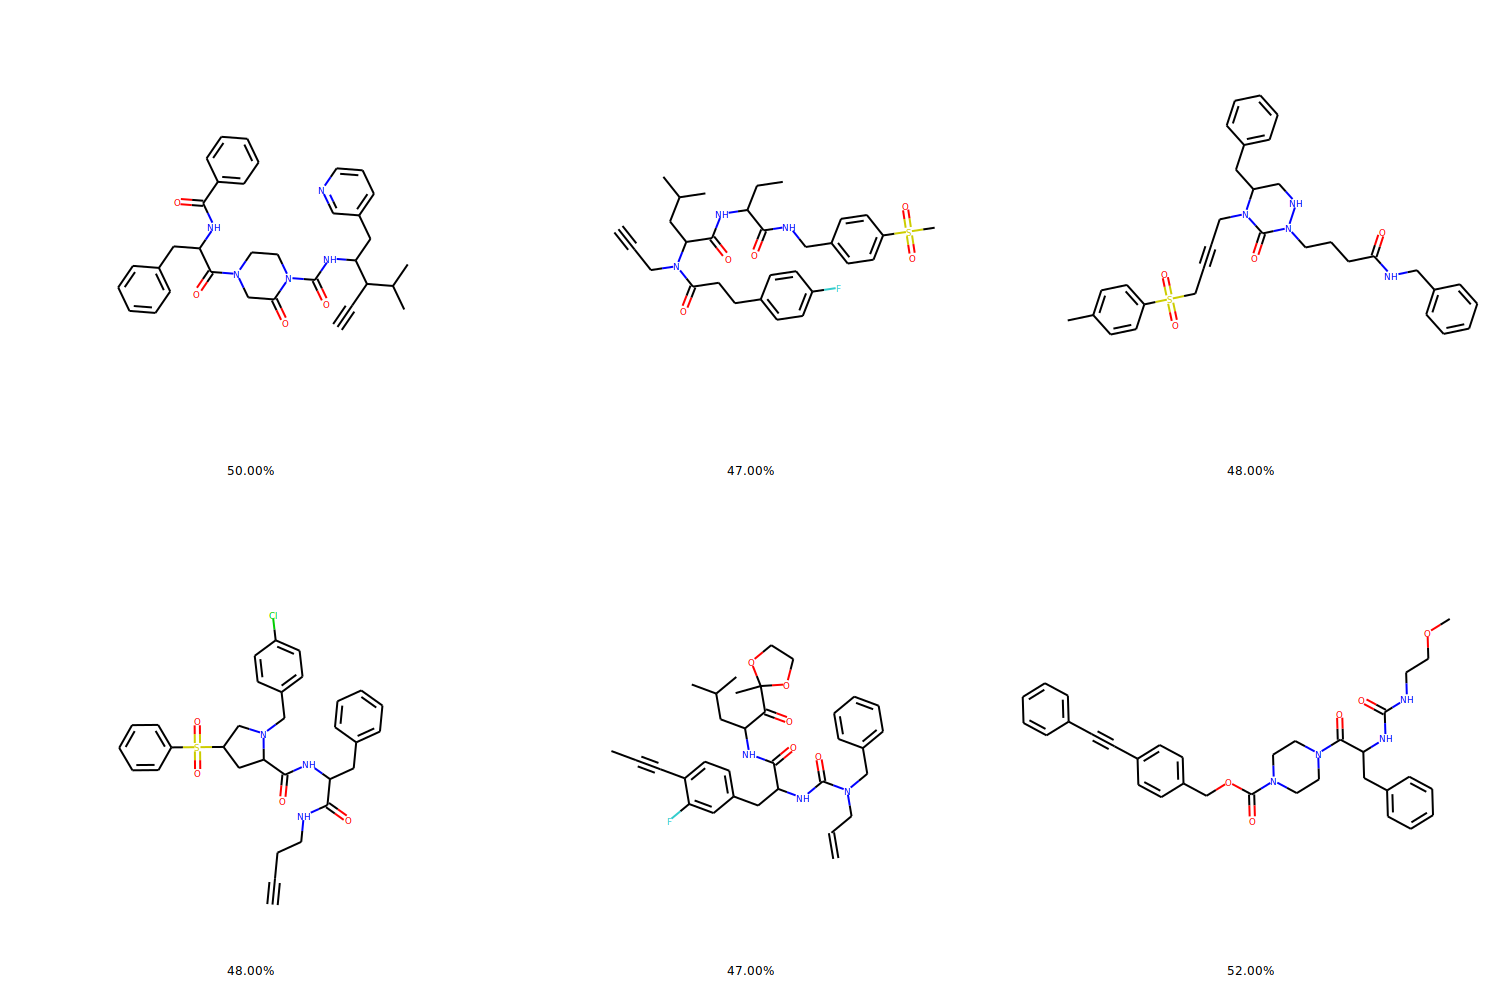

In [45]:
Chem.Draw.MolsToGridImage(mols[:6], legends=tani[:6],molsPerRow=3,subImgSize=(500,500))

### View Pivo in new dataset

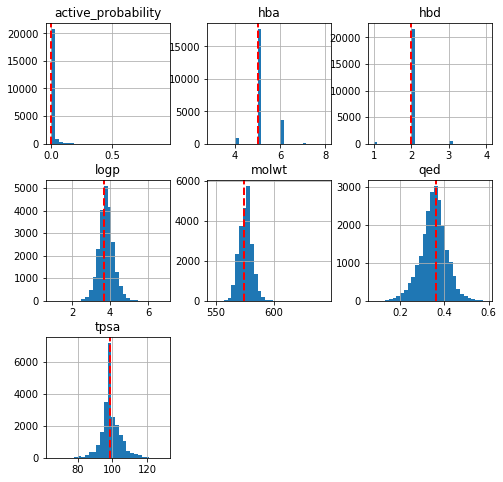

In [46]:
target_dict = {t[0]:t[1] for t in zip(data.columns, [smiles_target] + conditions)}
axes = data.hist(bins=30,figsize=(8,8))
for i, ax in enumerate(axes.flatten()):
    title = ax.title.__dict__["_text"]
    if title:
        ax.axvline(x=target_dict[title], color='r', linestyle='dashed', linewidth=2)

## Find new ligans in Chembl

In [110]:
import sqlite3

In [119]:
con_ligs = sqlite3.connect("../chembl_analyser/data/ligantes_k777.db")

In [120]:
data_com_tanimoto.to_sql("novos_ligantes", con_ligs, index=False, if_exists="replace")

In [115]:
con = sqlite3.connect("../chembl_analyser/data/propriedades.db")

In [116]:
data_2 = pd.read_sql("select * from dados", con)

In [117]:
data_2

,chembl_id,mw_freebase,alogp,psa,rtb,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,canonical_smiles
0,CHEMBL287510,357.45400,1.51190,73.83000,10.00000,nan,8.79000,1.80000,0.40000,BASE,357.45000,2.00000,26.00000,0.56000,357.20520,5.00000,3.00000,0.00000,CN(C)c1ccccc1C(=O)NCCNCC(O)COc1ccccc1
1,CHEMBL285301,320.43300,1.71240,70.59000,9.00000,nan,8.79000,1.96000,0.55000,BASE,320.43000,2.00000,23.00000,0.61000,320.21000,4.00000,3.00000,0.00000,O=C(NCCNCC(O)COc1ccccc1)C1CCCCC1
2,CHEMBL285413,255.31400,1.41230,48.95000,8.00000,nan,7.42000,1.45000,1.14000,NEUTRAL,255.31000,1.00000,18.00000,0.71000,255.14710,5.00000,1.00000,0.00000,COc1ccc(OC)c(CNCC(OC)OC)c1
3,CHEMBL24475,262.34900,3.64890,46.53000,8.00000,9.95000,nan,4.40000,4.40000,NEUTRAL,262.35000,1.00000,19.00000,0.57000,262.15690,3.00000,1.00000,0.00000,CCCC/C=C/C(=O)CCc1ccc(O)c(OC)c1
4,CHEMBL24545,330.46800,4.45000,43.37000,2.00000,nan,nan,4.21000,4.21000,NEUTRAL,330.47000,4.00000,24.00000,0.70000,330.21950,3.00000,0.00000,0.00000,CCC(=O)OC1CCC2C3CCC4=CC(=O)CCC4C3CCC12C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2084583,CHEMBL4110107,507.53800,4.47270,105.57000,8.00000,11.72000,3.32000,3.13000,3.13000,NEUTRAL,507.54000,4.00000,35.00000,0.47000,507.15520,7.00000,2.00000,1.00000,Cc1cc(N=S2(=O)CCC2)cc2ncnc(Nc3ccc(F)cc3O[C@H](...
2084584,CHEMBL4110108,337.33500,3.03200,76.68000,2.00000,11.84000,5.74000,2.11000,2.10000,NEUTRAL,337.34000,5.00000,25.00000,0.78000,337.10630,5.00000,1.00000,0.00000,O=C1OC[C@H](c2ccc3c(c2)OCCO3)N1c1ccc2nc[nH]c2c1
2084585,CHEMBL4110109,338.78500,4.11530,41.99000,7.00000,nan,7.09000,3.66000,3.49000,NEUTRAL,338.79000,2.00000,23.00000,0.77000,338.09970,3.00000,1.00000,0.00000,CC[C@@H](NCCF)c1ccc(Cl)c(C(=O)c2cccnc2)c1F
2084586,CHEMBL4110110,480.96800,3.12660,96.81000,10.00000,nan,3.97000,3.19000,3.19000,NEUTRAL,480.97000,3.00000,33.00000,0.54000,480.19400,7.00000,2.00000,0.00000,CC(C(=O)NCCF)c1ccc(O[C@@H]2CCN(c3ncnc(OCC(C)(C...


### If not in data then unique ligand

In [118]:
data_2.query("canonical_smiles in @data_com_tanimoto.Smiles")

,chembl_id,mw_freebase,alogp,psa,rtb,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,canonical_smiles
